### Initial configuration

In [3]:
import sympy as smp
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last'

In [4]:
plt.rcParams['figure.figsize'] = (5,4)

## Moment of inertia

### Initial conditions

In [5]:
E = 200e9

vertices = list(zip(
    (0, 15e-2, 15e-2, 10e-2, 10e-2, 5e-2, 5e-2, 0), #x-координаты вершин
    (0, 0, 5e-2, 5e-2, 10e-2, 10e-2, 5e-2, 5e-2) #y-координаты вершин
    ))
# vertices = [tuple(smp.S(num) for num in vertex) for vertex in vertices] #float -> sympy
vertices.append(vertices[0]) #замыкает многоугольник

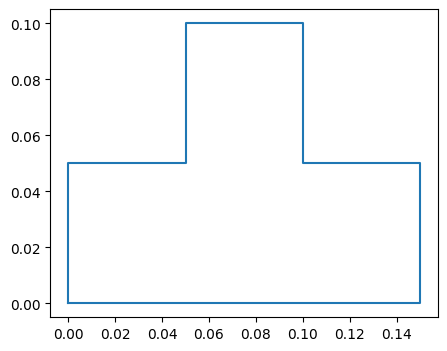

In [6]:
fig, ax = plt.subplots()
ax.plot(*zip(*vertices))
plt.show()

### Moments of area

In [9]:
A = np.abs(sum(vertices[i][0]*vertices[i+1][1] - vertices[i+1][0]*vertices[i][1] for i in range(len(vertices)-1))/2) #площадь
c = (
    np.abs(sum((vertices[i][0] + vertices[i+1][0])*(vertices[i][0]*vertices[i+1][1] - vertices[i+1][0]*vertices[i][1]) for i in range(len(vertices)-1))/(6*A)),
    np.abs(sum((vertices[i][1] + vertices[i+1][1])*(vertices[i][0]*vertices[i+1][1] - vertices[i+1][0]*vertices[i][1]) for i in range(len(vertices)-1))/(6*A))
    ) #координаты центра масс
Jx = np.abs(sum((vertices[i][0]*vertices[i+1][1] - vertices[i+1][0]*vertices[i][1])*(vertices[i][1]**2 + vertices[i][1]*vertices[i+1][1] + vertices[i+1][1]**2) for i in range(len(vertices)-1))/12) #момент инеции относительно x
Jcx = Jx - A*c[1]**2 #момент инерции относительно оси, параллельной x и проходящей через центр масс

In [202]:
A, c, Jcx

(0.010000000000000002, (0.075, 0.0375), 5.677083333333332e-05)

## Internal forces

### Initial conditions

In [170]:
eps = smp.symbols('varepsilon', positive=True)

parameters = smp.symbols('q a M', positive=True) #параметры. Символы y0, dy0, N, t зарезервированы
q, a, M = parameters
parameter_values = [1e5, 1, 5e4] #значения параметров если даны, иначе None

x = smp.symbols('x')

In [171]:
l = 3*a #длина балки
x_rigid = [] #точки жёсткого крепления
x_hinge = [0, a, 2*a] #точки шарнирного крепления
q = smp.Piecewise((q, (a <= x) & (x < 2*a)), (0, True)) #распределённая сила
F, xF = [], [] #силы и точки их приложения кроме реакций опор
t, xt = [M], [3*a] #моменты сил и точки их приложения кроме реакций опор

In [172]:
y0, dy0 = smp.symbols('y0, dy0') #y и y' при x = 0
N_base, t_base = smp.IndexedBase('N'), smp.IndexedBase('t') #силы и моменты реакций опор

F_contact = [N_base[i] for i in range(len(x_rigid) + len(x_hinge))]
F.extend(F_contact)
xF.extend(x_rigid + x_hinge)
t_contact = [t_base[i] for i in range(len(x_rigid))]
t.extend(t_contact)
xt.extend(x_rigid)
pieces = [coord for coord in sorted(xF + xt)]

variables = (y0, dy0, *F_contact, *t_contact)

In [173]:
display(smp.Tuple(F, xF))
display(smp.Tuple(t, xt))

([N[0], N[1], N[2]], [0, a, 2*a])

([M], [3*a])

### Integration

In [174]:
simp = lambda func: smp.Piecewise(
    *[(func.subs(x, pieces[i]+eps).subs(eps, x-pieces[i]).subs(x, pieces[i+1]-eps).subs(eps, pieces[i+1]-x).simplify(),
       ((pieces[i] < x) & (x < pieces[i+1]))) for i in range(len(pieces)-1)])
disp = lambda funcs: display(*[simp(func) for func in funcs.values()])

In [175]:
funcs = {}
manual = False
# simp = lambda func: smp.piecewise_fold(func.rewrite(smp.Piecewise)).simplify()

funcs['Q'] = smp.integrate(q, (x,0,x), manual=manual) + sum(Fi*smp.Heaviside(x-xi) for Fi, xi in zip(F, xF))
funcs['M'] = -smp.integrate(funcs['Q'], (x,0,x), manual=manual) + sum(ti*smp.Heaviside(x-xi) for ti, xi in zip(t, xt))
funcs['dy'] = dy0 + smp.integrate(funcs['M'], (x,0,x), manual=manual)
funcs['y'] = y0 + smp.integrate(funcs['dy'], (x,0,x), manual=manual)

In [176]:
disp(funcs)

Piecewise((N[0], (a > x) & (x > 0)), (-a*q + q*x + N[0] + N[1], (a < x) & (x < 2*a)), (a*q + N[0] + N[1] + N[2], (x > 2*a) & (x < 3*a)))

Piecewise((-x*N[0], (a > x) & (x > 0)), (-a**2*q/2 + a*q*x + a*N[1] - q*x**2/2 - x*N[0] - x*N[1], (a < x) & (x < 2*a)), (3*a**2*q/2 - a*q*x + a*N[1] + 2*a*N[2] - x*N[0] - x*N[1] - x*N[2], (x > 2*a) & (x < 3*a)))

Piecewise((dy0 - x**2*N[0]/2, (a > x) & (x > 0)), (a**3*q/6 - a**2*q*x/2 - a**2*N[1]/2 + a*q*x**2/2 + a*x*N[1] + dy0 - q*x**3/6 - x**2*N[0]/2 - x**2*N[1]/2, (a < x) & (x < 2*a)), (-7*a**3*q/6 + 3*a**2*q*x/2 - a**2*N[1]/2 - 2*a**2*N[2] - a*q*x**2/2 + a*x*N[1] + 2*a*x*N[2] + dy0 - x**2*N[0]/2 - x**2*N[1]/2 - x**2*N[2]/2, (x > 2*a) & (x < 3*a)))

Piecewise((dy0*x - x**3*N[0]/6 + y0, (a > x) & (x > 0)), (-a**4*q/24 + a**3*q*x/6 + a**3*N[1]/6 - a**2*q*x**2/4 - a**2*x*N[1]/2 + a*q*x**3/6 + a*x**2*N[1]/2 + dy0*x - q*x**4/24 - x**3*N[0]/6 - x**3*N[1]/6 + y0, (a < x) & (x < 2*a)), (5*a**4*q/8 - 7*a**3*q*x/6 + a**3*N[1]/6 + 4*a**3*N[2]/3 + 3*a**2*q*x**2/4 - a**2*x*N[1]/2 - 2*a**2*x*N[2] - a*q*x**3/6 + a*x**2*N[1]/2 + a*x**2*N[2] + dy0*x - x**3*N[0]/6 - x**3*N[1]/6 - x**3*N[2]/6 + y0, (x > 2*a) & (x < 3*a)))

### Solving for contact forces

In [177]:
eq_system = [
    funcs['Q'].subs(x, l+eps).subs(eps, 0), #сумма всех сил
    funcs['M'].subs(x, l+eps).subs(eps, 0), #сумма всех моментов сил
    *[funcs['y'].subs(x, coord) for coord in x_rigid + x_hinge], #условия крепления
    *[funcs['dy'].subs(x, coord) for coord in x_rigid]
]

In [178]:
display(*eq_system)

a*q + N[0] + N[1] + N[2]

M - 3*a**2*q/2 - a*(-a*q + N[0] + N[1]) - a*(a*q + N[0] + N[1] + N[2]) - a*N[0]

y0

-a**3*N[0]/6 + a*dy0 + y0

-5*a**4*q/8 + 7*a**3*(a*q/6 - N[0]/6 - N[1]/6) - a**3*N[0]/6 + 3*a**2*(-a**2*q/4 + a*N[1]/2) + a*dy0 + a*(a**3*q/6 - a**2*N[1]/2 + dy0) + y0

In [179]:
solution = smp.linsolve(eq_system, *variables)
assert len(solution) == 1, 'Решение не единственно'
variable_values = list(solution)[0]
display(smp.Tuple(*variables))
display(variable_values)

(y0, dy0, N[0], N[1], N[2])

(0, -M*a/24 + a**3*q/96, (-4*M + a**2*q)/(16*a), (12*M - 5*a**2*q)/(8*a), (-20*M - 7*a**2*q)/(16*a))

### Variables substitution

In [182]:
funcs_var_subs = {func_name: func.subs(zip(variables, variable_values)) for func_name, func in funcs.items()}

In [183]:
disp(funcs_var_subs)

Piecewise((-M/(4*a) + a*q/16, (a > x) & (x > 0)), (5*M/(4*a) - 25*a*q/16 + q*x, (a < x) & (x < 2*a)), (0, (x > 2*a) & (x < 3*a)))

Piecewise((x*(4*M - a**2*q)/(16*a), (a > x) & (x > 0)), ((2*a*(12*M - 9*a**2*q - 4*q*x**2) + 5*x*(-4*M + 5*a**2*q))/(16*a), (a < x) & (x < 2*a)), (-M, (x > 2*a) & (x < 3*a)))

Piecewise(((a**2*(-4*M + a**2*q) + 3*x**2*(4*M - a**2*q))/(96*a), (a > x) & (x > 0)), ((-76*M*a**2 + 144*M*a*x - 60*M*x**2 + 47*a**4*q - 108*a**3*q*x + 75*a**2*q*x**2 - 16*a*q*x**3)/(96*a), (a < x) & (x < 2*a)), (41*M*a/24 - M*x + a**3*q/32, (x > 2*a) & (x < 3*a)))

Piecewise((x*(4*M - a**2*q)*(-a**2 + x**2)/(96*a), (a > x) & (x > 0)), ((24*M*a**3 - 76*M*a**2*x + 72*M*a*x**2 - 20*M*x**3 - 14*a**5*q + 47*a**4*q*x - 54*a**3*q*x**2 + 25*a**2*q*x**3 - 4*a*q*x**4)/(96*a), (a < x) & (x < 2*a)), (-17*M*a**2/12 + 41*M*a*x/24 - M*x**2/2 - a**4*q/16 + a**3*q*x/32, (x > 2*a) & (x < 3*a)))

### Parameters substitution

In [184]:
assert parameter_values is not None, 'Параметры не заданы'
funcs_param_subs = {func_name: func.subs(zip(parameters, parameter_values)) for func_name, func in funcs_var_subs.items()}
l_subs = l.subs(zip(parameters, parameter_values))

In [192]:
display(*[smp.piecewise_fold(func.rewrite(smp.Piecewise)).simplify() for func in funcs_param_subs.values()])

Piecewise((0, x < 0), (-3125.0, Eq(x, 0)), (-6250.0, x < 1), (0, Eq(x, 1)), (100000.0*x - 93750.0, x < 2), (53125.0, Eq(x, 2)), (0, True))

Piecewise((0, x < 0), (-50000.0, (x >= 2) & (x < 3)), (-25000.0, Eq(x, 3)), (0, x >= 2), (-50000.0*x**2 + 93750.0*x - 37500.0, (x >= 1) & (x < 3)), (-50000.0*x**2 + 93750.0*x + 12500.0, x >= 1), (6250.0*x, x < 3), (6250.0*x + 50000.0, True))

Piecewise((-1041.66666666667, x < 0), (-61458.3333333333, x >= 3), (88541.6666666667 - 50000.0*x, x >= 2), (-16666.6666666667*x**3 + 46875.0*x**2 - 37500.0*x + 9375.0, x >= 1), (3125.0*x**2 - 1041.66666666667, True))

Piecewise((-1041.66666666667*x, x < 0), (1.36424205265939e-12*x**3 - 61458.3333333333*x + 147916.666666667, x >= 3), (1.36424205265939e-12*x**3 - 25000.0*x**2 + 88541.6666666667*x - 77083.3333333334, x >= 2), (-4166.66666666667*x**4 + 15625.0*x**3 - 18750.0*x**2 + 9375.00000000001*x - 2083.33333333334, x >= 1), (x*(1041.66666666667*x**2 - 1041.66666666666), True))

## Final results

### Plotting

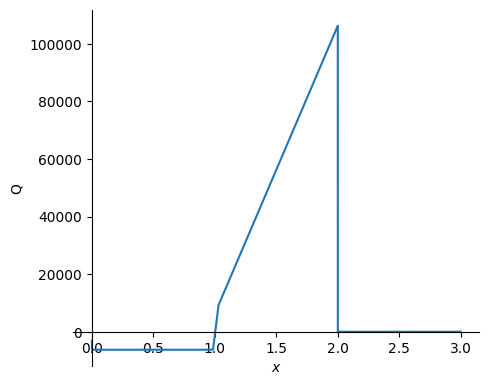

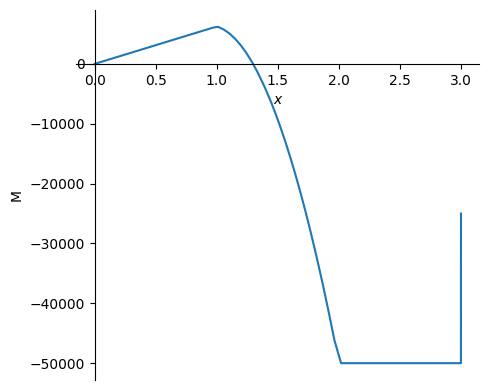

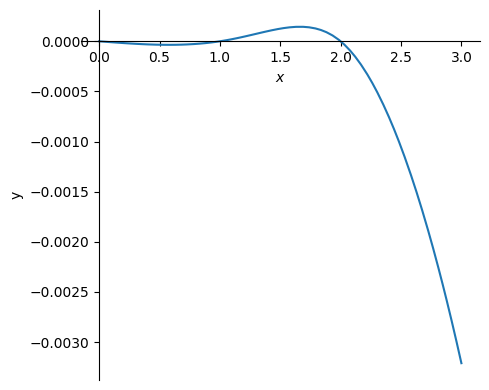

In [203]:
smp.plotting.plot(funcs_param_subs['Q'], (x,0,l_subs), ylabel='Q')
plt.show()
smp.plotting.plot(funcs_param_subs['M'], (x,0,l_subs), ylabel='M')
plt.show()
smp.plotting.plot(funcs_param_subs['y']/E/Jcx, (x,0,l_subs), ylabel='y')
plt.show()

In [204]:
funcs_vect = {func_name: np.vectorize(smp.lambdify(x, func)) for func_name, func in funcs_param_subs.items()}

c:\Users\georg\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2412: RuntimeWarning: invalid value encountered in _lambdifygenerated (vectorized)
  outputs = ufunc(*inputs)


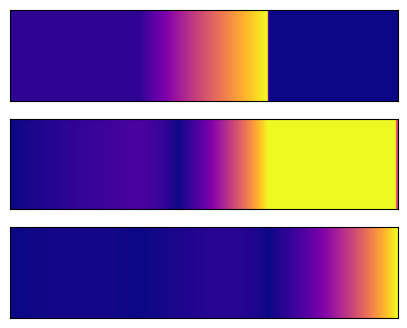

In [205]:
fig, axes = plt.subplots(3,1)
xp = np.linspace(0,float(l_subs),200)
xp = np.vstack((xp, xp))
for ax, func in zip(axes, (funcs_vect['Q'], funcs_vect['M'], funcs_vect['y'])):
    ax.imshow(np.abs(func(xp)), aspect='auto', cmap='plasma')
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()